# Import data

In [3]:
!git clone https://github.com/IanPorada/IFT6135_assignment_2.git

Cloning into 'IFT6135_assignment_2'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 12 (delta 2), reused 2 (delta 0), pack-reused 3
Unpacking objects: 100% (12/12), done.


In [4]:
%cd IFT6135_assignment_2/

/content/IFT6135_assignment_2


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!cp -r "/content/drive/My Drive/PB4_1/" ./PB4_1/

In [0]:
import matplotlib.pyplot as plt

# Models

In [0]:
grads = []
def my_hook(grad):
    grads.append(grad.norm().item())

In [9]:
import torch
import torch.nn as nn

import numpy as np
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
from collections import OrderedDict

# Use the GPU if you have one
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda")
else:
    print(
        "WARNING: You are about to run on cpu, and this will likely run out \
      of memory. \n You can try setting batch_size=1 to reduce memory usage"
    )
    device = torch.device("cpu")


def clones(module, N):
    "A helper function for producing N identical layers (each with their own parameters)."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


# Problem 1
class RNN(nn.Module):
    def __init__(
        self,
        emb_size,
        hidden_size,
        seq_len,
        batch_size,
        vocab_size,
        num_layers,
        dp_keep_prob,
    ):
        """
        emb_size:     The numvwe of units in the input embeddings
        hidden_size:  The number of hidden units per layer
        seq_len:      The length of the input sequences
        vocab_size:   The number of tokens in the vocabulary (10,000 for Penn TreeBank)
        num_layers:   The depth of the stack (i.e. the number of hidden layers at
                      each time-step)
        dp_keep_prob: The probability of *not* dropping out units in the
                      non-recurrent connections.
                      Do not apply dropout on recurrent connections.
        """
        super(RNN, self).__init__()

        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.dp_keep_prob = dp_keep_prob

        # model = nn.ModuleDict().to(device)
        # self.embedding = WordEmbedding(emb_size, vocab_size).to(device)
        # input_size = emb_size
        # for i in range(num_layers):
        # model[f"Wx{i}"] = nn.Linear(input_size, hidden_size)
        # model[f"Wh{i}"] = nn.Linear(hidden_size, hidden_size, bias=False)
        # input_size = hidden_size
        # self.fc = nn.Linear(hidden_size, vocab_size).to(device)
        # self.dropout = nn.Dropout(1 - dp_keep_prob).to(device)
        # self.tanh = nn.Tanh().to(device)

        self.embedding = nn.Embedding(vocab_size, emb_size).to(device)
        first_layer = nn.Linear(self.emb_size + self.hidden_size, self.hidden_size).to(
            device
        )
        self.model_rnn = nn.ModuleList([first_layer]).to(device)
        rest_layer = nn.Linear(2 * self.hidden_size, self.hidden_size).to(device)
        self.model_rnn.extend(clones(rest_layer, self.num_layers - 1))  # RNN Layer

        self.linear_layers = clones(
            nn.Linear(hidden_size, hidden_size), num_layers - 1
        ).to(
            device
        )  # FC Layers
        self.linear_layers.append(nn.Linear(hidden_size, vocab_size))

        self.dropout_layers = clones(nn.Dropout(p=1 - dp_keep_prob), num_layers).to(
            device
        )  # Dropout Layers :
        self.input_emb = nn.Dropout(p=1 - dp_keep_prob).to(device)

        self.init_weights_uniform()

    def init_weights_uniform(self):
        torch.nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        # nn.init.uniform_(self.embedding.lut.weight, -0.1, 0.1)
        # nn.init.uniform_(self.fc.weight, -0.1, 0.1)
        # nn.init.zeros_(self.fc.bias)
        torch.nn.init.uniform_(self.linear_layers[-1].weight, -0.1, 0.1)
        torch.nn.init.zeros_(self.linear_layers[-1].bias)

        for layer in self.model_rnn:
            for param in layer.modules():
                if type(param) == nn.Linear:
                    torch.nn.init.uniform_(
                        param.weight,
                        -math.sqrt(1 / self.hidden_size),
                        math.sqrt(1 / self.hidden_size),
                    )
                    if param.bias is not None:
                        torch.nn.init.uniform_(
                            param.bias,
                            -math.sqrt(1 / self.hidden_size),
                            math.sqrt(1 / self.hidden_size),
                        )

    def init_hidden(self):
        """
        This is used for the first mini-batch in an epoch, only.
        """
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(
            device
        )

    def forward(self, inputs, hidden):
        """
        Arguments:
            - inputs: A mini-batch of input sequences, composed of integers that
                        represent the index of the current token(s) in the vocabulary.
                            shape: (seq_len, batch_size)
            - hidden: The initial hidden states for every layer of the stacked RNN.
                            shape: (num_layers, batch_size, hidden_size)

        Returns:
            - Logits for the softmax over output tokens at every time-step.
                  **Do NOT apply softmax to the outputs!**
                  Pytorch's CrossEntropyLoss function (applied in ptb-lm.py) does
                  this computation implicitly.
                        shape: (seq_len, batch_size, vocab_size)
            - The final hidden states for every layer of the stacked RNN.
                  These will be used as the initial hidden states for all the
                  mini-batches in an epoch, except for the first, where the return
                  value of self.init_hidden will be used.
                  See the repackage_hiddens function in ptb-lm.py for more details,
                  if you are curious.
                        shape: (num_layers, batch_size, hidden_size)
        """
        # timesteps = len(inputs)
        # logits = torch.zeros(
        # (self.seq_len, self.batch_size, self.vocab_size), requires_grad=True
        # ).to(device)
        # inputs = self.dropout(self.embedding(inputs))
        # for ts in range(timesteps):
        # ts_input = inputs[ts]
        # for i in range(self.num_layers):
        # hidden[i] = self.tanh(
        # self.model[f"Wx{i}"](ts_input)
        # + self.model[f"Wh{i}"](hidden[i].clone())
        # )
        # ts_input = self.dropout(hidden[i].clone())
        # logits[ts] = self.fc(ts_input)

        emb_inputs = self.embedding(inputs)
        emb_inputs = self.input_emb(emb_inputs)

        logits = torch.zeros(
            [self.seq_len, self.batch_size, self.vocab_size],
            dtype=hidden.dtype,
            device=hidden.device,
        )

        for seq in range(self.seq_len):
            for j in range(self.num_layers):
                if j == 0:

                    next_hidden = torch.tanh(
                        self.model_rnn[j](torch.cat([hidden[j], emb_inputs[seq]], 1))
                    )
                    next_hidden.register_hook(my_hook)
                    hidden[j] = next_hidden
                    outputs = self.dropout_layers[j](hidden[j])
                    # outputs.register_hook(my_hook)
                else:

                    next_hidden = torch.tanh(
                        self.model_rnn[j](torch.cat([hidden[j], outputs], 1))
                    )
                    next_hidden.register_hook(my_hook)
                    hidden[j] = next_hidden
                    outputs = self.dropout_layers[j](hidden[j])
                    
                    if j == self.num_layers - 1:

                        logits[seq] = self.linear_layers[j](outputs)
        return logits.view(self.seq_len, self.batch_size, self.vocab_size), hidden

    def generate(self, inputs, hidden, generated_seq_len):
        """
        Arguments:
            - input: A mini-batch of input tokens (NOT sequences!)
                            shape: (batch_size)
            - hidden: The initial hidden states for every layer of the stacked RNN.
                            shape: (num_layers, batch_size, hidden_size)
            - generated_seq_len: The length of the sequence to generate.
                           Note that this can be different than the length used
                           for training (self.seq_len)
        Returns:
            - Sampled sequences of tokens
                        shape: (generated_seq_len, batch_size)
        """
        samples = []
        orig_seq_len = self.seq_len
        self.seq_len = 1
        seed = inputs.view(1, *inputs.shape)
        for i in range(generated_seq_len):
            samples.append(
                torch.max(nn.Softmax(2)(self.forward(seed, hidden)[0]), 2)[1]
            )
            seed = samples[-1]

        self.seq_len = orig_seq_len
        samples = torch.stack(samples)
        return samples


# Problem 2
class GRU(nn.Module):  # Implement a stacked GRU RNN
    """
    Follow the same instructions as for RNN (above), but use the equations for
    GRU, not Vanilla RNN.
    """

    def __init__(
        self,
        emb_size,
        hidden_size,
        seq_len,
        batch_size,
        vocab_size,
        num_layers,
        dp_keep_prob,
    ):
        super(GRU, self).__init__()

        self.emb_size = emb_size
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.vocab_size = vocab_size
        self.num_layers = num_layers
        self.dp_keep_prob = dp_keep_prob

        # self.embedding = WordEmbedding(emb_size, vocab_size).to(
        #     device
        # )  # Word Embedding Layer
        
        self.embedding = nn.Embedding(vocab_size, emb_size).to(device)

        self.model = nn.ModuleDict().to(device)
        input_size = self.emb_size
        for i in range(self.num_layers):
            self.model[f"Wr{i}"] = nn.Linear(input_size, hidden_size)
            self.model[f"Ur{i}"] = nn.Linear(hidden_size, hidden_size, bias=False)
            self.model[f"Wz{i}"] = nn.Linear(input_size, hidden_size)
            self.model[f"Uz{i}"] = nn.Linear(hidden_size, hidden_size, bias=False)
            self.model[f"Wh{i}"] = nn.Linear(input_size, hidden_size)
            self.model[f"Uh{i}"] = nn.Linear(hidden_size, hidden_size, bias=False)
            input_size = hidden_size

        self.fc = nn.Linear(hidden_size, vocab_size).to(device)
        self.dropout = nn.Dropout(p=1 - dp_keep_prob).to(device)
        self.tanh = nn.Tanh().to(device)
        self.sigm = nn.Sigmoid().to(device)

        self.init_weights_uniform()

    def init_weights_uniform(self):
        nn.init.uniform_(self.embedding.weight, -0.1, 0.1)
        nn.init.uniform_(self.fc.weight, -0.1, 0.1)
        nn.init.zeros_(self.fc.bias)

    def init_hidden(self):
        return torch.zeros(self.num_layers, self.batch_size, self.hidden_size).to(
            device
        )

    def forward(self, inputs, hidden):
        logits = torch.zeros(
            [self.seq_len, self.batch_size, self.vocab_size], requires_grad=True
        ).to(device)
        for seq in range(self.seq_len):
            ts_input = self.dropout(self.embedding(inputs[seq]))
            for i in range(self.num_layers):
                r = self.sigm(
                    self.model[f"Wr{i}"](ts_input)
                    + self.model[f"Ur{i}"](hidden[i].clone())
                )
                z = self.sigm(
                    self.model[f"Wz{i}"](ts_input)
                    + self.model[f"Uz{i}"](hidden[i].clone())
                )
                h = self.tanh(
                    self.model[f"Wh{i}"](ts_input)
                    + self.model[f"Uh{i}"](r * hidden[i].clone())
                )
                next_hidden = (1 - z) * hidden[i].clone() + z * h
                next_hidden.register_hook(my_hook)
                hidden[i] = next_hidden
                outputs = self.dropout(hidden[i])
                ts_input = outputs
            logits[seq] = self.fc(outputs)
        return logits.view(self.seq_len, self.batch_size, self.vocab_size), hidden

    def generate(self, inputs, hidden, generated_seq_len):
        """
        Arguments:
            - input: A mini-batch of input tokens (NOT sequences!)
                            shape: (batch_size)
            - hidden: The initial hidden states for every layer of the stacked RNN.
                            shape: (num_layers, batch_size, hidden_size)
            - generated_seq_len: The length of the sequence to generate.
                           Note that this can be different than the length used
                           for training (self.seq_len)
        Returns:
            - Sampled sequences of tokens
                        shape: (generated_seq_len, batch_size)
        """
        samples = []
        orig_seq_len = self.seq_len
        self.seq_len = 1
        seed = inputs.view(1, *inputs.shape)
        for i in range(generated_seq_len):
            samples.append(
                torch.max(nn.Softmax(2)(self.forward(seed, hidden)[0]), 2)[1]
            )
            seed = samples[-1]

        self.seq_len = orig_seq_len
        samples = torch.stack(samples)
        return samples


# Problem 3
##############################################################################
#
# Code for the Transformer model
#
##############################################################################

"""
Implement the MultiHeadedAttention module of the transformer architecture.
All other necessary modules have already been implemented for you.

We're building a transfomer architecture for next-step prediction tasks, and
applying it to sequential language modelling. We use a binary "mask" to specify
which time-steps the model can use for the current prediction.
This ensures that the model only attends to previous time-steps.

The model first encodes inputs using the concatenation of a learned WordEmbedding
and a (in our case, hard-coded) PositionalEncoding.
The word embedding maps a word's one-hot encoding into a dense real vector.
The positional encoding 'tags' each element of an input sequence with a code that
identifies it's position (i.e. time-step).

These encodings of the inputs are then transformed repeatedly using multiple
copies of a TransformerBlock.
This block consists of an application of MultiHeadedAttention, followed by a
standard MLP; the MLP applies *the same* mapping at every position.
Both the attention and the MLP are applied with Resnet-style skip connections,
and layer normalization.

The complete model consists of the embeddings, the stacked transformer blocks,
and a linear layer followed by a softmax.
"""

# This code has been modified from an open-source project, by David Krueger.
# The original license is included below:
# MIT License
#
# Copyright (c) 2018 Alexander Rush
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.


# ----------------------------------------------------------------------------------

# implement this class
class MultiHeadedAttention(nn.Module):
    def __init__(self, n_heads, n_units, dropout=0.1):
        """
        n_heads: the number of attention heads
        n_units: the number of output units
        dropout: probability of DROPPING units
        """
        super(MultiHeadedAttention, self).__init__()
        # This sets the size of the keys, values, and queries (self.d_k) to all
        # be equal to the number of output units divided by the number of heads.
        self.d_k = n_units // n_heads
        # This requires the number of n_heads to evenly divide n_units.
        assert n_units % n_heads == 0
        self.n_units = n_units

        # create/initialize any necessary parameters or layers
        # Note: the only Pytorch modules you are allowed to use are nn.Linear
        # and nn.Dropout

        self.n_heads = n_heads

        # Create 4 embedding layers. One for each of Q, K, V, and output.
        embedding_layer = nn.Linear(n_units, n_units)
        self.embedding_layers = clones(embedding_layer, 4)

        ki = np.sqrt(1 / n_units)
        for l in self.embedding_layers:
            nn.init.uniform_(l.weight, -ki, ki)

        self.dropout_layer = nn.Dropout(p=dropout)

    # A single attention head given Q, K, V embeddings
    def SingleAttention(self, query, key, value, mask=None, dropout_layer=None):
        # Matrix multiply Q and K
        soft_attention = torch.matmul(query, key)

        # Scale soft attention
        soft_attention = soft_attention / np.sqrt(self.d_k)

        # Mask
        epsilon = 1e9
        if mask is not None:
            # soft_attention = torch.mul(soft_attention, mask)
            # Subtract epsilon for numerical stability.
            # soft_attention = soft_attention - eps * (1 - mask)
            # we can simply use masked fill following the given
            # implementation with epsilon as per the assignment description
            soft_attention = soft_attention.masked_fill(mask == 0, -epsilon)

        # Softmax on the ouputs
        soft_attention = F.softmax(soft_attention, dim=-1)

        # Dropout
        if dropout_layer is not None:
            soft_attention = dropout_layer(soft_attention)

        # Apply attention
        output = torch.matmul(soft_attention, value)

        return output

    def forward(self, query, key, value, mask=None):
        # implement the masked multi-head attention.
        # query, key, and value all have size: (batch_size, seq_len, self.n_units, self.d_k)
        # mask has size: (batch_size, seq_len, seq_len)
        # As described in the .tex, apply input masking to the softmax
        # generating the "attention values" (i.e. A_i in the .tex)
        # Also apply dropout to the attention values.

        batch_size = query.size(0)
        seq_len = query.size(1)

        if mask is not None:
            # Same mask applied to all h heads.
            # mask = mask.view(batch_size, 1, seq_len, seq_len)
            mask = mask.unsqueeze(1)

        query_embedding = (
            self.embedding_layers[0](query)
            .view(batch_size, seq_len, self.n_heads, self.d_k)
            .transpose(1, 2)
        )

        key_embedding = (
            self.embedding_layers[1](key)
            .view(batch_size, seq_len, self.n_heads, self.d_k)
            .transpose(1, 2)
            .transpose(-2, -1)
        )

        value_embedding = (
            self.embedding_layers[2](value)
            .view(batch_size, seq_len, self.n_heads, self.d_k)
            .transpose(1, 2)
        )

        output = self.SingleAttention(
            query_embedding, key_embedding, value_embedding, mask, self.dropout_layer
        ).transpose(1, 2)
        # Concatenate outputs for each head
        output = output.contiguous().view(batch_size, seq_len, self.n_heads * self.d_k)

        output_embedding = self.embedding_layers[3](output)

        return output_embedding


# ----------------------------------------------------------------------------------
# The encodings of elements of the input sequence


class WordEmbedding(nn.Module):
    def __init__(self, n_units, vocab):
        super(WordEmbedding, self).__init__()
        self.lut = nn.Embedding(vocab, n_units)
        self.n_units = n_units

    def forward(self, x):
        # print (x)
        return self.lut(x) * math.sqrt(self.n_units)


class PositionalEncoding(nn.Module):
    def __init__(self, n_units, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, n_units)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(
            torch.arange(0, n_units, 2).float() * -(math.log(10000.0) / n_units)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + Variable(self.pe[:, : x.size(1)], requires_grad=False)
        return self.dropout(x)


# ----------------------------------------------------------------------------------
# The TransformerBlock and the full Transformer


class TransformerBlock(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(TransformerBlock, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(ResidualSkipConnectionWithLayerNorm(size, dropout), 2)

    def forward(self, x, mask):
        x = self.sublayer[0](
            x, lambda x: self.self_attn(x, x, x, mask)
        )  # apply the self-attention
        return self.sublayer[1](x, self.feed_forward)  # apply the position-wise MLP


class TransformerStack(nn.Module):
    """
    This will be called on the TransformerBlock (above) to create a stack.
    """

    def __init__(self, layer, n_blocks):  # layer will be TransformerBlock (below)
        super(TransformerStack, self).__init__()
        self.layers = clones(layer, n_blocks)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


class FullTransformer(nn.Module):
    def __init__(self, transformer_stack, embedding, n_units, vocab_size):
        super(FullTransformer, self).__init__()
        self.transformer_stack = transformer_stack
        self.embedding = embedding
        self.output_layer = nn.Linear(n_units, vocab_size)

    def forward(self, input_sequence, mask):
        embeddings = self.embedding(input_sequence)
        return F.log_softmax(
            self.output_layer(self.transformer_stack(embeddings, mask)), dim=-1
        )


def make_model(vocab_size, n_blocks=6, n_units=512, n_heads=16, dropout=0.1):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(n_heads, n_units)
    ff = MLP(n_units, dropout)
    position = PositionalEncoding(n_units, dropout)
    model = FullTransformer(
        transformer_stack=TransformerStack(
            TransformerBlock(n_units, c(attn), c(ff), dropout), n_blocks
        ),
        embedding=nn.Sequential(WordEmbedding(n_units, vocab_size), c(position)),
        n_units=n_units,
        vocab_size=vocab_size,
    )

    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model


# ----------------------------------------------------------------------------------
# Data processing


def subsequent_mask(size):
    """ helper function for creating the masks. """
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype("uint8")
    return torch.from_numpy(subsequent_mask) == 0


class Batch:
    "Object for holding a batch of data with mask during training."

    def __init__(self, x, pad=0):
        self.data = x
        self.mask = self.make_mask(self.data, pad)

    @staticmethod
    def make_mask(data, pad):
        "Create a mask to hide future words."
        mask = (data != pad).unsqueeze(-2)
        mask = mask & Variable(subsequent_mask(data.size(-1)).type_as(mask.data))
        return mask


# ----------------------------------------------------------------------------------
# Some standard modules


class LayerNorm(nn.Module):
    "layer normalization, as in: https://arxiv.org/abs/1607.06450"

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


class ResidualSkipConnectionWithLayerNorm(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(ResidualSkipConnectionWithLayerNorm, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


class MLP(nn.Module):
    """
    This is just an MLP with 1 hidden layer
    """

    def __init__(self, n_units, dropout=0.1):
        super(MLP, self).__init__()
        self.w_1 = nn.Linear(n_units, 2048)
        self.w_2 = nn.Linear(2048, n_units)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))


Using the GPU


# argv

In [0]:
import sys

In [0]:
# test_arg_string = 'pt-lmb.py --model=RNN --optimizer=ADAM --initial_lr=0.0001 --batch_size=20 --seq_len=35 --hidden_size=1500 --num_layers=2 --dp_keep_prob=0.35 --save_best'

test_arg_string = 'pt-lmb.py --model=GRU --optimizer=SGD_LR_SCHEDULE --initial_lr=10 --batch_size=20 --seq_len=35 --hidden_size=1500 --num_layers=2 --dp_keep_prob=0.35 --save_best'

# test_arg_string = 'pt-lmb.py --model=TRANSFORMER --optimizer=SGD_LR_SCHEDULE --initial_lr=20 --batch_size=128 --seq_len=35 --hidden_size=512 --num_layers=6 --dp_keep_prob=0.9 --save_best'

sys.argv = test_arg_string.split(' ')

# ptb-lm.py

In [19]:
#!/bin/python
# coding: utf-8

# Code outline/scaffold for
# ASSIGNMENT 2: RNNs, Attention, and Optimization
# By Tegan Maharaj, David Krueger, and Chin-Wei Huang
# IFT6135 at University of Montreal
# Winter 2019
#
# based on code from:
#    https://github.com/deeplearningathome/pytorch-language-model/blob/master/reader.py
#    https://github.com/ceshine/examples/blob/master/word_language_model/main.py
#    https://github.com/teganmaharaj/zoneout/blob/master/zoneout_word_ptb.py
#    https://github.com/harvardnlp/annotated-transformer

# GENERAL INSTRUCTIONS:
#    - ! IMPORTANT!
#      Unless we're otherwise notified we will run exactly this code, importing
#      your models from models.py to test them. If you find it necessary to
#      modify or replace this script (e.g. if you are using TensorFlow), you
#      must justify this decision in your report, and contact the TAs as soon as
#      possible to let them know. You are free to modify/add to this script for
#      your own purposes (e.g. monitoring, plotting, further hyperparameter
#      tuning than what is required), but remember that unless we're otherwise
#      notified we will run this code as it is given to you, NOT with your
#      modifications.
#    - We encourage you to read and understand this code; there are some notes
#      and comments to help you.
#    - Typically, all of your code to submit should be written in models.py;
#      see further instructions at the top of that file / in TODOs.
#          - RNN recurrent unit
#          - GRU recurrent unit
#          - Multi-head attention for the Transformer
#    - Other than this file and models.py, you will probably also write two
#      scripts. Include these and any other code you write in your git repo for
#      submission:
#          - Plotting (learning curves, loss w.r.t. time, gradients w.r.t. hiddens)
#          - Loading and running a saved model (computing gradients w.r.t. hiddens,
#            and for sampling from the model)

# PROBLEM-SPECIFIC INSTRUCTIONS:
#    - For Problems 1-3, paste the code for the RNN, GRU, and Multi-Head attention
#      respectively in your report, in a monospace font.
#    - For Problem 4.1 (model comparison), the hyperparameter settings you should run are as follows:
#          --model=RNN --optimizer=ADAM --initial_lr=0.0001 --batch_size=20 --seq_len=35 --hidden_size=1500 --num_layers=2 --dp_keep_prob=0.35 --save_best
#          --model=GRU --optimizer=SGD_LR_SCHEDULE --initial_lr=10 --batch_size=20 --seq_len=35 --hidden_size=1500 --num_layers=2 --dp_keep_prob=0.35 --save_best
#          --model=TRANSFORMER --optimizer=SGD_LR_SCHEDULE --initial_lr=20 --batch_size=128 --seq_len=35 --hidden_size=512 --num_layers=6 --dp_keep_prob=0.9 --save_best
#    - In those experiments, you should expect to see approximately the following
#      perplexities:
#                  RNN: train:  120  val: 157
#                  GRU: train:   65  val: 104
#          TRANSFORMER:  train:  67  val: 146
#    - For Problem 4.2 (exploration of optimizers), you will make use of the
#      experiments from 4.1, and should additionally run the following experiments:
#          --model=RNN --optimizer=SGD --initial_lr=0.0001 --batch_size=20 --seq_len=35 --hidden_size=1500 --num_layers=2 --dp_keep_prob=0.35
#          --model=GRU --optimizer=SGD --initial_lr=10 --batch_size=20 --seq_len=35 --hidden_size=1500 --num_layers=2 --dp_keep_prob=0.35
#          --model=TRANSFORMER --optimizer=SGD --initial_lr=20 --batch_size=128 --seq_len=35 --hidden_size=512 --num_layers=6 --dp_keep_prob=.9
#          --model=RNN --optimizer=SGD_LR_SCHEDULE --initial_lr=1 --batch_size=20 --seq_len=35 --hidden_size=512 --num_layers=2 --dp_keep_prob=0.35
#          --model=GRU --optimizer=ADAM --initial_lr=0.0001 --batch_size=20 --seq_len=35 --hidden_size=1500 --num_layers=2 --dp_keep_prob=0.35
#          --model=TRANSFORMER --optimizer=ADAM --initial_lr=0.001 --batch_size=128 --seq_len=35 --hidden_size=512 --num_layers=2 --dp_keep_prob=.9
#    - For Problem 4.3 (exloration of hyperparameters), do your best to get
#      better validation perplexities than the settings given for 4.1. You may
#      try any combination of the hyperparameters included as arguments in this
#      script's ArgumentParser, but do not implement any additional
#      regularizers/features. You may (and will probably want to) run a lot of
#      different things for just 1-5 epochs when you are trying things out, but
#      you must report at least 3 experiments on each architecture that have run
#      for at least 40 epochs.
#    - For Problem 5, perform all computations / plots based on saved models
#      from Problem 4.1. NOTE this means you don't have to save the models for
#      your exploration, which can make things go faster. (Of course
#      you can still save them if you like; just add the flag --save_best).
#    - For Problem 5.1, you can modify the loss computation in this script
#      (search for "LOSS COMPUTATION" to find the appropriate line. Remember to
#      submit your code.
#    - For Problem 5.3, you must implement the generate method of the RNN and
#      GRU.  Implementing this method is not considered part of problems 1/2
#      respectively, and will be graded as part of Problem 5.3


import argparse
import time
import collections
import os
import sys
import torch
import torch.nn
from torch.autograd import Variable
import torch.nn as nn
import numpy

np = numpy

# NOTE ==============================================
# This is where your models are imported
# from models import RNN, GRU
# from models import make_model as TRANSFORMER
TRANSFORMER = make_model


##############################################################################
#
# ARG PARSING AND EXPERIMENT SETUP
#
##############################################################################

parser = argparse.ArgumentParser(description="PyTorch Penn Treebank Language Modeling")

# Arguments you may need to set to run different experiments in 4.1 & 4.2.
parser.add_argument(
    "--data",
    type=str,
    default="data",
    help="location of the data corpus. We suggest you change the default\
                    here, rather than passing as an argument, to avoid long file paths.",
)
parser.add_argument(
    "--model",
    type=str,
    default="GRU",
    help="type of recurrent net (RNN, GRU, TRANSFORMER)",
)
parser.add_argument(
    "--optimizer",
    type=str,
    default="SGD_LR_SCHEDULE",
    help="optimization algo to use; SGD, SGD_LR_SCHEDULE, ADAM",
)
parser.add_argument(
    "--seq_len",
    type=int,
    default=35,
    help="number of timesteps over which BPTT is performed",
)
parser.add_argument("--batch_size", type=int, default=20, help="size of one minibatch")
parser.add_argument(
    "--initial_lr", type=float, default=20.0, help="initial learning rate"
)
parser.add_argument(
    "--hidden_size",
    type=int,
    default=200,
    help="size of hidden layers. IMPORTANT: for the transformer\
                    this must be a multiple of 16.",
)
parser.add_argument(
    "--save_best",
    action="store_true",
    help="save the model for the best validation performance",
)
parser.add_argument(
    "--num_layers",
    type=int,
    default=2,
    help="number of hidden layers in RNN/GRU, or number of transformer blocks in TRANSFORMER",
)

# Other hyperparameters you may want to tune in your exploration
parser.add_argument("--emb_size", type=int, default=200, help="size of word embeddings")
parser.add_argument(
    "--num_epochs", type=int, default=40, help="number of epochs to stop after"
)
parser.add_argument(
    "--dp_keep_prob",
    type=float,
    default=0.35,
    help="dropout *keep* probability. drop_prob = 1-dp_keep_prob \
                    (dp_keep_prob=1 means no dropout)",
)

# Arguments that you may want to make use of / implement more code for
parser.add_argument("--debug", action="store_true")
parser.add_argument(
    "--save_dir",
    type=str,
    default="",
    help="path to save the experimental config, logs, model \
                    This is automatically generated based on the command line \
                    arguments you pass and only needs to be set if you want a \
                    custom dir name",
)
parser.add_argument(
    "--evaluate",
    action="store_true",
    help="use this flag to run on the test set. Only do this \
                    ONCE for each model setting, and only after you've \
                    completed ALL hyperparameter tuning on the validation set.\
                    Note we are not requiring you to do this.",
)

# DO NOT CHANGE THIS (setting the random seed makes experiments deterministic,
# which helps for reproducibility)
parser.add_argument("--seed", type=int, default=1111, help="random seed")

args = parser.parse_args()
argsdict = args.__dict__
argsdict["code_file"] = sys.argv[0]

# Use the model, optimizer, and the flags passed to the script to make the
# name for the experimental dir
print("\n########## Setting Up Experiment ######################")
flags = [flag.lstrip("--").replace("/", "").replace("\\", "") for flag in sys.argv[1:]]
experiment_path = os.path.join(
    args.save_dir + "_".join([argsdict["model"], argsdict["optimizer"]] + flags)
)

# Increment a counter so that previous results with the same args will not
# be overwritten. Comment out the next four lines if you only want to keep
# the most recent results.
i = 0
if args.model == "TRANSFORMER":
    i = 2
# while os.path.exists(experiment_path + "_" + str(i)):
#     i += 1
experiment_path = experiment_path + "_" + str(i)

# Creates an experimental directory and dumps all the args to a text file
if not os.path.exists(experiment_path):
    os.mkdir(experiment_path)
print("\nPutting log in %s" % experiment_path)
argsdict["save_dir"] = experiment_path
with open(os.path.join(experiment_path, "exp_config.txt"), "w") as f:
    for key in sorted(argsdict):
        f.write(key + "    " + str(argsdict[key]) + "\n")

# Set the random seed manually for reproducibility.
torch.manual_seed(args.seed)

# Use the GPU if you have one
if torch.cuda.is_available():
    print("Using the GPU")
    device = torch.device("cuda")
else:
    print(
        "WARNING: You are about to run on cpu, and this will likely run out \
      of memory. \n You can try setting batch_size=1 to reduce memory usage"
    )
    device = torch.device("cpu")


###############################################################################
#
# LOADING & PROCESSING
#
###############################################################################

# HELPER FUNCTIONS
def _read_words(filename):
    with open(filename, "r") as f:
        return f.read().replace("\n", "<eos>").split()


def _build_vocab(filename):
    data = _read_words(filename)

    counter = collections.Counter(data)
    count_pairs = sorted(counter.items(), key=lambda x: (-x[1], x[0]))

    words, _ = list(zip(*count_pairs))
    word_to_id = dict(zip(words, range(len(words))))
    id_to_word = dict((v, k) for k, v in word_to_id.items())

    return word_to_id, id_to_word


def _file_to_word_ids(filename, word_to_id):
    data = _read_words(filename)
    return [word_to_id[word] for word in data if word in word_to_id]


# Processes the raw data from text files
def ptb_raw_data(data_path=None, prefix="ptb"):
    train_path = os.path.join(data_path, prefix + ".train.txt")
    valid_path = os.path.join(data_path, prefix + ".valid.txt")
    test_path = os.path.join(data_path, prefix + ".test.txt")

    word_to_id, id_2_word = _build_vocab(train_path)
    train_data = _file_to_word_ids(train_path, word_to_id)
    valid_data = _file_to_word_ids(valid_path, word_to_id)
    test_data = _file_to_word_ids(test_path, word_to_id)
    return train_data, valid_data, test_data, word_to_id, id_2_word


# Yields minibatches of data
def ptb_iterator(raw_data, batch_size, num_steps):
    raw_data = np.array(raw_data, dtype=np.int32)

    data_len = len(raw_data)
    batch_len = data_len // batch_size
    data = np.zeros([batch_size, batch_len], dtype=np.int32)
    for i in range(batch_size):
        data[i] = raw_data[batch_len * i : batch_len * (i + 1)]

    epoch_size = (batch_len - 1) // num_steps

    if epoch_size == 0:
        raise ValueError("epoch_size == 0, decrease batch_size or num_steps")

    for i in range(epoch_size):
        x = data[:, i * num_steps : (i + 1) * num_steps]
        y = data[:, i * num_steps + 1 : (i + 1) * num_steps + 1]
        yield (x, y)


class Batch:
    "Data processing for the transformer. This class adds a mask to the data."

    def __init__(self, x, pad=-1):
        self.data = x
        self.mask = self.make_mask(self.data, pad)

    @staticmethod
    def make_mask(data, pad):
        "Create a mask to hide future words."

        def subsequent_mask(size):
            """ helper function for creating the masks. """
            attn_shape = (1, size, size)
            subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype("uint8")
            return torch.from_numpy(subsequent_mask) == 0

        mask = (data != pad).unsqueeze(-2)
        mask = mask & Variable(subsequent_mask(data.size(-1)).type_as(mask.data))
        return mask


# LOAD DATA
print("Loading data from " + args.data)
raw_data = ptb_raw_data(data_path=args.data)
train_data, valid_data, test_data, word_to_id, id_2_word = raw_data
vocab_size = len(word_to_id)
print("  vocabulary size: {}".format(vocab_size))


###############################################################################
#
# MODEL SETUP
#
###############################################################################

# NOTE ==============================================
# This is where your model code will be called. You may modify this code
# if required for your implementation, but it should not typically be necessary,
# and you must let the TAs know if you do so.
if args.model == "RNN":
    model = RNN(
        emb_size=args.emb_size,
        hidden_size=args.hidden_size,
        seq_len=args.seq_len,
        batch_size=args.batch_size,
        vocab_size=vocab_size,
        num_layers=args.num_layers,
        dp_keep_prob=args.dp_keep_prob,
    )
elif args.model == "GRU":
    model = GRU(
        emb_size=args.emb_size,
        hidden_size=args.hidden_size,
        seq_len=args.seq_len,
        batch_size=args.batch_size,
        vocab_size=vocab_size,
        num_layers=args.num_layers,
        dp_keep_prob=args.dp_keep_prob,
    )
elif args.model == "TRANSFORMER":
    if args.debug:  # use a very small model
        model = TRANSFORMER(vocab_size=vocab_size, n_units=16, n_blocks=2)
    else:
        # Note that we're using num_layers and hidden_size to mean slightly
        # different things here than in the RNNs.
        # Also, the Transformer also has other hyperparameters
        # (such as the number of attention heads) which can change it's behavior.
        model = TRANSFORMER(
            vocab_size=vocab_size,
            n_units=args.hidden_size,
            n_blocks=args.num_layers,
            dropout=1.0 - args.dp_keep_prob,
        )
    # these 3 attributes don't affect the Transformer's computations;
    # they are only used in run_epoch
    model.batch_size = args.batch_size
    model.seq_len = args.seq_len
    model.vocab_size = vocab_size
else:
    print("Model type not recognized.")

# Load existing params from .pt file.
load_model_params = True
if load_model_params:
    pretrained_state_dict = torch.load(os.path.join("./PB4_1/", args.save_dir, "best_params.pt"))
    model.load_state_dict(pretrained_state_dict)
    model.eval()

model = model.to(device)

# LOSS FUNCTION
loss_fn = nn.CrossEntropyLoss()
if args.optimizer == "ADAM":
    optimizer = torch.optim.Adam(model.parameters(), lr=args.initial_lr)

# LEARNING RATE SCHEDULE
lr = args.initial_lr
lr_decay_base = 1 / 1.15
m_flat_lr = 14.0  # we will not touch lr for the first m_flat_lr epochs





########## Setting Up Experiment ######################

Putting log in GRU_SGD_LR_SCHEDULE_model=GRU_optimizer=SGD_LR_SCHEDULE_initial_lr=10_batch_size=20_seq_len=35_hidden_size=1500_num_layers=2_dp_keep_prob=0.35_save_best_0
Using the GPU
Loading data from data
  vocabulary size: 10000


# sample

In [0]:
###############################################################################
#
# DEFINE COMPUTATIONS FOR PROCESSING ONE EPOCH
#
###############################################################################


def repackage_hidden(h):
    """
    Wraps hidden states in new Tensors, to detach them from their history.

    This prevents Pytorch from trying to backpropagate into previous input
    sequences when we use the final hidden states from one mini-batch as the
    initial hidden states for the next mini-batch.

    Using the final hidden states in this way makes sense when the elements of
    the mini-batches are actually successive subsequences in a set of longer sequences.
    This is the case with the way we've processed the Penn Treebank dataset.
    """
    if isinstance(h, Variable):
        return h.detach_()
    else:
        return tuple(repackage_hidden(v) for v in h)


def run_epoch(model, data, is_train=False, lr=1.0):
    """
    One epoch of training/validation (depending on flag is_train).
    """
    if is_train:
        model.train()
    else:
        model.eval()
    epoch_size = ((len(data) // model.batch_size) - 1) // model.seq_len
    start_time = time.time()
    if args.model != "TRANSFORMER":
        hidden = model.init_hidden()
        hidden = hidden.to(device)
    costs = 0.0
    iters = 0
    losses = []

    # LOOP THROUGH MINIBATCHES
    for step, (x, y) in enumerate(ptb_iterator(data, model.batch_size, model.seq_len)):
        if args.model == "TRANSFORMER":
            batch = Batch(torch.from_numpy(x).long().to(device))
            model.zero_grad()
            outputs = model.forward(batch.data, batch.mask).transpose(1, 0)
            # print ("outputs.shape", outputs.shape)
        else:
            inputs = (
                torch.from_numpy(x.astype(np.int64))
                .transpose(0, 1)
                .contiguous()
                .to(device)
            )  # .cuda()
            model.zero_grad()
            hidden = repackage_hidden(hidden)
            outputs, hidden = model(inputs, hidden)

        targets = (
            torch.from_numpy(y.astype(np.int64)).transpose(0, 1).contiguous().to(device)
        )  # .cuda()
        tt = torch.squeeze(targets.view(-1, model.batch_size * model.seq_len))

        # LOSS COMPUTATION
        # This line currently averages across all the sequences in a mini-batch
        # and all time-steps of the sequences.
        # For problem 5.3, you will (instead) need to compute the average loss
        # at each time-step separately.
        loss = loss_fn(outputs.contiguous().view(-1, model.vocab_size), tt)
        costs += loss.data.item() * model.seq_len
        losses.append(costs)
        iters += model.seq_len
        if args.debug:
            print(step, loss)
        if is_train:  # Only update parameters if training
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
            if args.optimizer == "ADAM":
                optimizer.step()
            else:
                for p in model.parameters():
                    if p.grad is not None:
                        p.data.add_(-lr, p.grad.data)
            if step % (epoch_size // 10) == 10:
                print(
                    "step: "
                    + str(step)
                    + "\t"
                    + "loss (sum over all examples' seen this epoch):"
                    + str(costs)
                    + "\t"
                    + "speed (wps):"
                    + str(iters * model.batch_size / (time.time() - start_time))
                )
    return np.exp(costs / iters), losses

def graph_losses(model, data, is_train=False, lr=1.0):
    """
    One epoch of training/validation (depending on flag is_train).
    """
    if is_train:
        model.train()
    else:
        model.eval()
    epoch_size = ((len(data) // model.batch_size) - 1) // model.seq_len
    start_time = time.time()
    if args.model != "TRANSFORMER":
        hidden = model.init_hidden()
        hidden = hidden.to(device)
    costs = 0.0
    iters = 0
    losses = []
    
    losses_per_t = torch.tensor([0.0] * model.seq_len)
    total_steps = 0

    # LOOP THROUGH MINIBATCHES
    for step, (x, y) in enumerate(ptb_iterator(data, model.batch_size, model.seq_len)):
        if args.model == "TRANSFORMER":
            batch = Batch(torch.from_numpy(x).long().to(device))
            model.zero_grad()
            outputs = model.forward(batch.data, batch.mask).transpose(1, 0)
            # print ("outputs.shape", outputs.shape)
        else:
            inputs = (
                torch.from_numpy(x.astype(np.int64))
                .transpose(0, 1)
                .contiguous()
                .to(device)
            )  # .cuda()
            model.zero_grad()
            hidden = repackage_hidden(hidden)
            outputs, hidden = model(inputs, hidden)

        targets = (
            torch.from_numpy(y.astype(np.int64)).transpose(0, 1).contiguous().to(device)
        )  # .cuda()
        tt = torch.squeeze(targets.view(-1, model.batch_size * model.seq_len))

        # LOSS COMPUTATION
        # This line currently averages across all the sequences in a mini-batch
        # and all time-steps of the sequences.
        # For problem 5.3, you will (instead) need to compute the average loss
        # at each time-step separately.
        loss = loss_fn(outputs.contiguous().view(-1, model.vocab_size), tt)
        costs += loss.data.item() * model.seq_len
        losses.append(costs)
        iters += model.seq_len
        
        # Calculate loss per time step.
        if not is_train:
            with torch.no_grad():
                for i in range(model.seq_len):
                    losses_per_t[i] += nn.functional.cross_entropy(outputs[i], targets[i])
                total_steps += 1
                
    if not is_train:
        plt.plot(list(range(1,36)), [l / total_steps for l in losses_per_t.numpy()])
        plt.xlabel('Timestep')
        plt.ylabel('Loss')
        plt.title('Loss per Timestep for ' + args.model)
        plt.show()
        
def graph_gradients(model, data):
    model.train()
    epoch_size = ((len(data) // model.batch_size) - 1) // model.seq_len

    
    hidden = model.init_hidden()
    hidden = hidden.to(device)
    
    for step, (x, y) in enumerate(ptb_iterator(data, model.batch_size, model.seq_len)):
        inputs = (
            torch.from_numpy(x.astype(np.int64))
                .transpose(0, 1)
                .contiguous()
                .to(device)
        )
        model.zero_grad()
        hidden = repackage_hidden(hidden)
        outputs, hidden = model(inputs, hidden)

        targets = (
            torch.from_numpy(y.astype(np.int64)).transpose(0, 1).contiguous().to(device)
        )
        
        tt = torch.squeeze(targets.view(-1, model.batch_size * model.seq_len))

        # LOSS COMPUTATION
        # This line currently averages across all the sequences in a mini-batch
        # and all time-steps of the sequences.
        # For problem 5.3, you will (instead) need to compute the average loss
        # at each time-step separately.
        
        # loss = loss_fn(outputs[-1], targets[-1])
        loss = loss_fn(outputs[-1].contiguous().view(-1, model.vocab_size), torch.squeeze(targets[-1].view(model.batch_size)))
        
        
        '''loss = loss_fn(outputs.contiguous().view(-1, model.vocab_size), tt)
        costs += loss.data.item() * model.seq_len
        losses.append(costs)
        iters += model.seq_len
        if args.debug:
            print(step, loss)'''
        
        loss.backward()
        # torch.nn.utils.clip_grad_norm_(model.parameters(), 0.25)
            
        '''grads = []
        for i in range(model.seq_len):
            norm = 0.0
            for j in range(model.num_layers):
                if model.hidden_results[j][i].requires_grad:
                    # print(model.hidden_results[j][i].grad)
                    norm += model.hidden_results[j][i].grad.norm()
            grads.append(norm)

        #print(grads)
        plt.plot(grads)
        plt.show()'''
            
            
        '''for p in model.parameters():
                if p.grad is not None:
                    p.data.add_(-lr, p.grad.data)'''
        break
        
    total_grads = []
    for i in range(0, len(grads), 2):
        total_grads += [grads[i] + grads[i+1]]
    plt.plot(list(range(1,36)), list(reversed(total_grads)))
    plt.xlabel('Timestep')
    plt.ylabel('Gradient Norm of Hidden States')
    plt.title('Gradients for ' + args.model)
    plt.show()

def generate_sequence(model, sample_len):
    model.seq_len = 1
    model.eval()
    
    # with torch.no_grad():
    hidden = model.init_hidden()
    hidden = hidden.to(device)
    next_hidden = None

    word_ids = [2]

    for i in range(sample_len):
        inputs = torch.ones((model.seq_len, model.batch_size), dtype=torch.int64).cpu()
        inputs[0][0] = word_ids[-1]

        inputs = inputs.to(device)
        outputs, next_hidden = model(inputs, hidden)

        outputs = outputs.cpu()

        next_word = torch.multinomial(nn.functional.softmax(outputs[0,0], dim=-1), 1).squeeze()

        word_ids += [next_word.item()]

        hidden = next_hidden
        
    return ' '.join([id_2_word[x] for x in word_ids[1:]])


# Results

In [21]:
###############################################################################
#
# RUN MAIN LOOP (TRAIN AND VAL)
#
###############################################################################

print("\n########## Running Problem 5 ##########################")
train_ppls = []
train_losses = []
val_ppls = []
val_losses = []
best_val_so_far = np.inf
times = []
grads = []

# In debug mode, only run one epoch
if args.debug:
    num_epochs = 1
else:
    num_epochs = args.num_epochs

# RUN MODEL ON VALIDATION DATA
# val_ppl, val_loss = run_epoch(model, valid_data)
# print('val_ppl', val_ppl)


########## Running Problem 5 ##########################


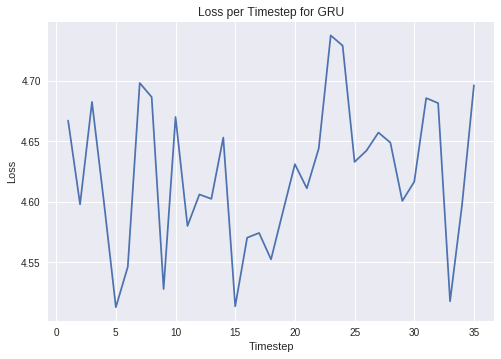

In [22]:
graph_losses(model, valid_data)

In [23]:
sent = None
if args.model != "TRANSFORMER":
    for slen in [35, 70]:
        for _ in range(10):
            sent = generate_sequence(model, slen)
            print(sent)

it 's issue to get her <unk> to hide experience we 're <unk> to very competitive says michael <unk> iii of solidarity 's <unk> basketball message in new york <eos> this is is <unk> <eos>
it 's hard to tell the truth says john goldberg a mining analyst at <unk> & co. a chicago firm there 's been a large program that is pushing for a delicate carpets <eos> junior
some californians have speculated that the default rate will be a <unk> order from near the irs and the newly held government of technology <eos> in addition N years ago will be the bank of
the company has sued a temporary chunk on a two-year entity in predicting in the fourth quarter of maintaining discount sales citing imported variety of other and quist beneficial or wire <unk> chips <eos> the
there was a lot of N then room for nine times were the same time but are favorable consideration <eos> traders said with investors are greeted by some market in the u.s. <eos> gte corp.
the theory is subject to removing definitive guide

ValueError: ignored

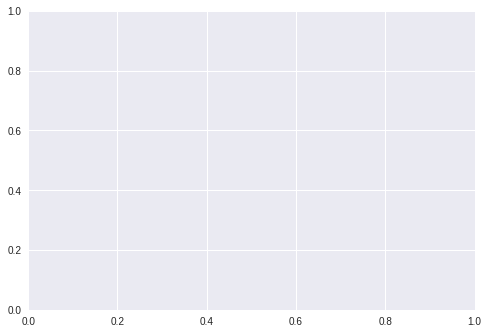

In [24]:
grads = []
if args.model != "TRANSFORMER":
    graph_gradients(model, train_data)

In [0]:
total_grads = []
for i in range(0, len(grads), 2):
    total_grads += [grads[i] + grads[i+1]]
    
total_grads2 = []
for i in range(0, len(gru_grads), 2):
    total_grads2 += [gru_grads[i] + gru_grads[i+1]]
    
total_grads = [t/max(total_grads) for t in total_grads]
total_grads2 = [t/max(total_grads2) for t in total_grads2]
    
plt.plot(list(range(1,36)), list(reversed(total_grads)), label='RNN')
plt.plot(list(range(1,36)), list(reversed(total_grads2)), label='GRU')
plt.xlabel('Timestep')
plt.ylabel('Gradient Norm of Hidden States')
plt.title('Normalized Gradients for RNN and GRU')
plt.legend()
plt.show()
